In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd

In [2]:
L = 2.5e6
pconst = L/1000/86400*997

In [3]:
models = ['CAM5_GCM',
 'CAM6_GCM',
 'CM1',
 'CNRM-CM6-1',
 'ECHAM6_GCM',
 'GEOS_GCM',
 'ICON_GCM',
 'ICON_LEM_CRM',
 'ICON_NWP_CRM',
 'MESONH',
 'MPAS',
 'NICAM',
 'SCALE',
 'UCLA-CRM']

In [6]:
def get_rad(models, type = 'rl', sst=300, size='large'):
    """
    size: 'small' or 'large'
     sst: 295, 300, or 305
    type: 'rl' or 'rs' for LW and SW respectively
    """
    
    pwd = "/home/tompkins-archive/tompkins/smr3952/RCEMIP/data"
    fnames = sorted(glob(f'{pwd}/*'))[2:]
    rlut_list = []
    rlutcs_list = []
    rlus_list = []
    rluscs_list = []
    
    for fname in fnames:
        model = fname.split('/')[-1]
        if model not in models:
            continue
        path1 = f'{pwd}/{model}'
        flist = glob(f'{path1}/*')
        fname = None
        fname_cs = None
        for fli in flist:
            if size in fli and str(sst) in fli:
                fname = fli
        flist = glob(f'{fname}/0D/*.nc')
        try:
            ds = xr.open_mfdataset(flist, combine='by_coords', compat='override', decode_times=False)
            ds = ds.isel(time=slice(len(ds.time.values)//5,None))
            ds = ds.mean('time')
        except:
            print(model, 'error')
            continue
    
        if f'{type}ut_avg' in list(ds.variables):
            rlut = ds[f'{type}ut_avg']
            rlus = ds[f'{type}us_avg']
            try:
                rlutcs = ds[f'{type}utcs_avg']
                rluscs = ds[f'{type}uscs_avg']
            except:
                continue
        elif f'{type}ut' in list(ds.variables):
            rlut = ds[f'{type}ut']
            rlus = ds[f'{type}us']
            try:
                rlutcs = ds[f'{type}utcs']
                rluscs = ds[f'{type}uscs']
            except:
                continue
        else:
            continue
    
        rlut_list.append(rlut.values.item())
        rlutcs_list.append(rlutcs.values.item())
        rlus_list.append(rlus.values.item())
        rluscs_list.append(rluscs.values.item())
        if rluscs_list[-1] < 30:
            rluscs_list[-1] = rlus_list[-1]
        # print(model, np.round(rlut_list[-1]), np.round(rlus_list[-1]), np.round(rlutcs_list[-1]), np.round(rluscs_list[-1]))
    
    
    rlut = np.array(rlut_list)
    rlutcs = np.array(rlutcs_list)
    rlus = np.array(rlus_list)
    rluscs = np.array(rluscs_list)
    
    return rlut, rlutcs, rlus, rluscs

In [8]:
rlut, rlutcs, rlus, rluscs = get_rl(models, type='rl', sst=300, size='large')
all_dif = rlut - rlus
cs_dif = rlutcs - rluscs

In [135]:
data = pd.read_csv("/home/tompkins-archive/tompkins/smr3952/RCEMIP/data/A-Statistics/0D/Table_A2_RCE_large300.csv")
data_305 = pd.read_csv("/home/tompkins-archive/tompkins/smr3952/RCEMIP/data/A-Statistics/0D/Table_A2_RCE_large305.csv")

In [136]:
p = np.array([data['Precip.'][data.Model==model.replace('_','-').replace('-1','')].item() for model in models[:-4]])
type = np.array([data['Unnamed: 1'][data.Model==model.replace('_','-').replace('-1','')].item() for model in models[:-4]])

array([], dtype='<U12')

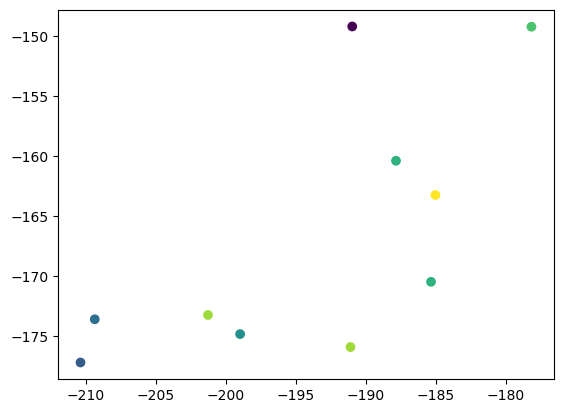

In [137]:
plt.scatter(all_dif[:-4], cs_dif[:-4], c=p)
np.array(models)[cs_dif>0]

Text(0.5, 1.0, 'LWCRE and P in 300K simulations')

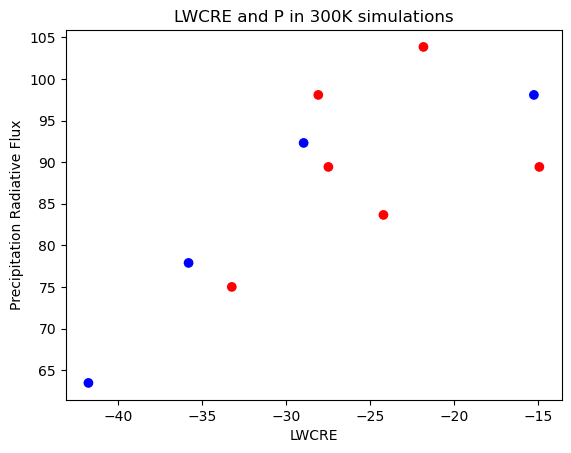

In [139]:
# column realtive humidity
type_c = ['red' if t=="P" else "blue" for t in type]
plt.scatter(all_dif[:-4] - cs_dif[:-4], p*pconst, c=type_c)
plt.xlabel("LWCRE")
plt.ylabel("Precipitation Radiative Flux")
plt.title('LWCRE and P in 300K simulations')